# Loading packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm,gamma,lognorm,pareto,spearmanr,pearsonr
import seaborn as sns
from scipy.interpolate import interp1d
import itertools
#from matplotlib import colors
plt.style.use('ggplot')
%matplotlib inline


# Introduction
In this notebook I illustrate how to simulate correlated random variables using a copula and the marginal distributions. 

I use the procedure to investigate how gender inequality interacts with the measurement of relative intergenerational mobility. The example is two-dimensional but can easily be extended to more dimensions. 

The notebook is accompanying a [working paper](https://drive.google.com/open?id=1rwdfCWnyD3ZIto24HHYGpFCRPXFkTzCz), where the setup and theory is described in greater detail. 

This is still a work in progress so any suggestions or correction of errors will be greatly appreciated. 


# Theory and assumptions

In this section, I'll briefly describe the assumptions and the protocol for simulation.

The purpose of this notebook is to simulate two correlated variables where the rank correlation is assumed apriori. The rank correlation is also known as Spearman's $\rho$. 

For this purpose, the theory of *copulas* come in handy.
A copula is defined as a joint distribution function of *ranks*, which by definition are distributed uniformly on the unit interval.

As per [Wikipedia](https://en.wikipedia.org/wiki/Copula_(probability_theory)):

> Sklar's theorem states that any multivariate joint distribution can be written in terms of univariate marginal distribution functions and a copula which describes the dependence structure between the variables.

## The Gaussian copula
In this notebook I make use of the Gaussian copula.

Let $U$ and $V$ be two sunch uniform random variables. In a biariate Gaussian copula the joint probability is defined by:

$$
C_{R}^{\text{Gauss}}(u,v)=\Phi _{R}\left(\Phi ^{-1}(u),\Phi ^{-1}(v)\right),
$$

where $\Phi$ is the standard normal univariate Gaussian cdf and $\Phi_R$ is a bivariate Gaussian cdf with correlation matrix $R$.

$R$ contains a single the sufficient parameter to fully describe the bivariate Gaussian copula:

$$
R=\begin{pmatrix}1&\rho^{{G}}\\\rho^{{G}}&1\end{pmatrix}
$$

The parameter $\rho^G$ maps 1:1 with Spearman's $\rho$ (the rank-rank-correlation). Thus it is sufficient to know Spearman's $rho$ to simulate in a Gaussian copula. The two parameters are related as follows:

$$
\rho^{{G}}=2\sin(\rho \frac{\pi}{6})
$$

Bu using these definitions, one can simulate $U$ and $V$ with the desired Spearman's $\rho$. Afterwards, it is (in principle) straight forward to go from ranks/scores to realized levels of variables by the relation $X=F_X^{-1}(U)$ and $Y=F_Y^{-1}(V)$

It is important to be aware of the limitation of Gaussian copulas including the lack of tail dependence, so conclusions from such simulations should be drawn with care.


## Simulation protocol

To draw two random variables with known spearman's $\rho$ the following protocol may be applied: 
* Draw two vectors, $L_U$,$L_V$ from a bivariate normal distribution with covariance matrix $R$ as described above.
* Apply the CDF of the standard normal to obtain $U$ and $V$: $U=\Phi(L_U)$, $V=\Phi(L_V)$
* Apply the desired quantile funcition (inverse cdf) to $U$ and $V$ to obtain the variable values following the desired marginal distribution.


# An example

In the following I will show how to apply this protocol in order to simulate coplas and the final distributions.

There are two separate cases to consider:
* Know distributions
    * Could be lognormal, gamma, pareto etc.
* Estimated distributions
    * Empirically estimated with Kernel Density Estimation (KDE)
    
While the copula simulation is the same for the two cases the way to get from ranks to levels differ a bit.





### Simulating the copula

The following function creates ranks, that is uniform variables with known Spearman's $\rho$ from a Gaussian copula. 

In [2]:
def ranks(n=2000,rho=0.2,spear=True):
    """
    Function to create vectors of rank with known rank correlation (Spearman's rho)
        --- Input 
            n: Number of observations desired, default is 2000
            rho: Correlation coefficient. If Spear==False then this parameter enters directly into the covariance matrix, R.
            spear: If True then rho is rescaled to fit the Gaussian copula.
        --- Output:
            Two uniformly distributed vectors with desired Spearman's rho.        
    """
    
    if spear:
        rho_G = 2*np.sin(rho*np.pi/6)
    else: 
        rho_G = rho
    
    R = np.array([[1,rho_G],
                [rho_G,1]])
    
    C = norm.cdf(np.random.multivariate_normal([0,0],R,size=n))
    U,V = C[:,0],C[:,1]
    
    return U,V

An example of how it is used can be seen below:

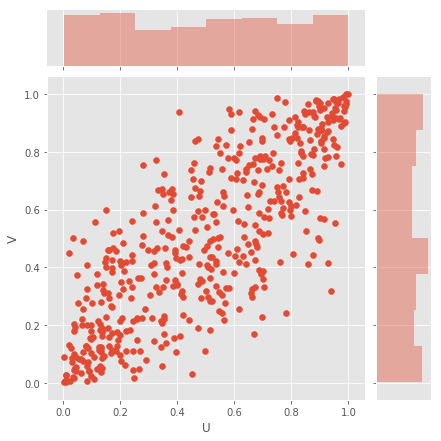

In [3]:
U,V = ranks(n=500,rho=0.8)
sns.jointplot(U,V).set_axis_labels("U", "V");


### Applying marginal distributions
Define marginal distribution. In this case I'll use a pareto and a gamma distribtion for $X$ and $Y$ respectively. 

In [4]:
distX = pareto(b=5)
distY = gamma(10, loc = 0., scale = 2.)

Apply the marginal distributions:

In [5]:
X = distX.ppf(U)
Y = distY.ppf(V)

Now when we visualize the data we can see the marginal distributions have changed:

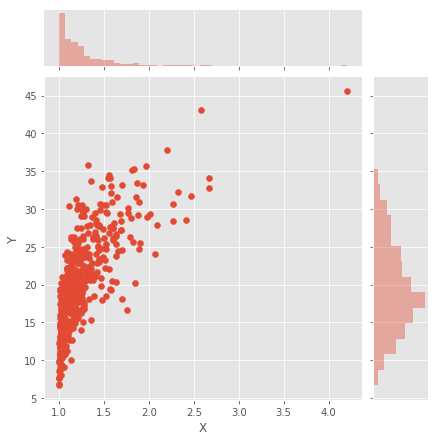

In [6]:
sns.jointplot(X,Y).set_axis_labels("X", "Y")
plt.show()

While the linear correlation coefficient is changed by the transformation of the marginal distributions the  the rank correlation is preserved:

In [7]:
print("Pearson's linear correlation coefficient between X and Y: %.2f \nRank correlation between X and Y: %.2f"%(pearsonr(X,Y)[0],spearmanr(X,Y)[0]))

Pearson's linear correlation coefficient between X and Y: 0.73 
Rank correlation between X and Y: 0.81


### Using estimated distributions

Let's say you want to use an empirically estimated distribution instead of an artificial distribution. I'll show how this is done, first by drawing from an artificial distribution, estimating the same distribution on the drawn sample and apply the estimate quantile function to the ranks.

As we have already created $X$ and $Y$ above we can start out by estimating these distributions with a Gaussian kernel. The implementation of quantile functions in Statsmodels is a bit cumbersome as it is necessary to interpolate the quantile function in order to apply it to the uniformly distributed variables. Thus the method for applying the estimated differs slightly from the method using known parametric distributions as described above.

In practice, with empirical distributions, you load the data into panda dataframes and just fill in data series instead of $X$ and $Y$.

In [8]:
distXe = sm.nonparametric.KDEUnivariate(X)
distXe.fit()

distYe = sm.nonparametric.KDEUnivariate(Y)
distYe.fit()

# Interpolate the quantile funtions for the domain of ranks, (0,1)
QfX = interp1d(np.linspace(0,1,distXe.icdf.shape[0]),distXe.icdf)
QfY = interp1d(np.linspace(0,1,distYe.icdf.shape[0]),distYe.icdf)

Now apply the estimated densities to the known ranks and visualise the data:

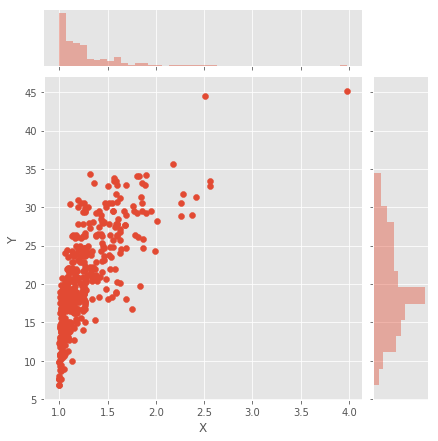

In [9]:
Xe = QfX(U)
Ye = QfY(V)
sns.jointplot(Xe,Ye).set_axis_labels("X", "Y")
plt.show()

Looks like the image above and the correlations are as before as seen below. We should expect as much given a proper estimation of the densities. Thus this illustrates how to retrieve a density from given variables.

In [10]:
print("Pearson's linear correlation coefficient between X and Y: %.2f \nRank correlation between X and Y: %.2f"%(pearsonr(Xe,Ye)[0],spearmanr(Xe,Ye)[0]))

Pearson's linear correlation coefficient between X and Y: 0.74 
Rank correlation between X and Y: 0.81


# Putting it all together
Below is an example of usage. In this setup, I let one gamma distribution approach another from below while maintaining a monotonic likelihood ratio which implies stochastic dominance. This resembles a process of a narrowing of the geender income gab, holding the "male" distribution fixed. 

In this context, define $F_0$ as the marginal cdf of males and $F_1$ as the marginal cdf of females. 

I then investigate what the random sorting into gender means for the "aggregate" Spearman's $\rho$. The sorting occurs via the variable binary random variable $S$. The mean is $w=0.5$ meaning the same number of men and women occur in a given sample.

The Gamma distribution takes $a$ as a parameter and the density is defined as 
$$
f(x, a) = \lambda^a  x^{(a-1)}  \exp(-\lambda x) / \Gamma(a)
$$

Thus the protocol is as follows:

* Define marginal distribution for group 1, $F_1$ (group 0 has the same distribution throughout, $F_0$)
    * For a value of $\rho\in(0,1)$:
        * Repeat $T$ times:
            * Draw $U$ and $V$ from the copula with $\rho$ as a rank correlation as described above
            * Draw group affiliation $S$ where $Pr(S=1)=E\left[\mathbf{1}(Group=0)\right]=w$
            * Apply marginal distributions to obtain income of child: $Y_c=S\times F_0^{-1}(V)+(1-S)\times F_1^{-1}(V)$
            * Calculate rank correlation of $U$ and $Y_c$, denote it $\hat \rho_t$ for $t\in T$. 
        * Calculate $\hat\rho=\frac{1}{T}\sum^T \rho_t$

I will only simulate for a positive range of Spearman's $rho$, that is $\rho\in(0,1)$. LIsts of the relevant parameters over which to simulate are defined below:

In [11]:
a_list = np.linspace(0.01,5,10) # List of a values for the female marginal distribution.
rho_list = np.linspace(0,0.999,100) # Values of Spearman's rho, note that these should be converted to rho_G as explained above.
dist0 = gamma(a_list[-1], loc = 0., scale = 2.) #Distribution of the stable group, takes last a in a_list as argument.

First plot the distributions. I plot the cdf and the likelihood ratio. The darker color implies * more * equality:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


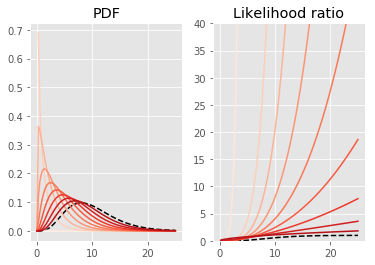

In [12]:
eval_range = np.linspace(0,25,100) # For plotting the distributions
map_color = itertools.cycle(sns.color_palette("Reds",len(a_list)))
fig,(ax1,ax2) = plt.subplots(1,2)

#Plot the stable distribution
ax1.plot(eval_range,dist0.pdf(eval_range),color='k',linestyle='--')
ax2.plot(eval_range,dist0.cdf(eval_range),color='k',linestyle='--')

#Plot the changing distributions
for a in a_list[:-1]:
    c = next(map_color)
    dist1 = gamma(a, loc = 0., scale = 2.)
    ax1.plot(eval_range,dist1.pdf(eval_range),color=c)
    ax2.plot(eval_range,dist0.pdf(eval_range)/dist1.pdf(eval_range),color=c)
ax2.set_ylim(0,40)
ax1.set_title('PDF')
ax2.set_title('Likelihood ratio')
plt.show()

Now for the simulation. In order to smooth out estimation noice, I perform $T$ simulations for each round. (May take some time to rum)

In [13]:
n = 2000 # Number of observations
T = 15 # Number of repititions
w = 0.5 # Probability of S=1

rho_hat_df = pd.DataFrame() # Dataframe to store final results
for a in a_list: 
    dist1 = gamma(a, loc = 0., scale = 2.) # Distribution for females
    rho_hat = []
    
    for r in rho_list:
        
        rho_hat_temp = [] 
        rho = 2*np.sin(r*np.pi/6)
        corr_s = np.array([[1,rho],
                           [rho,1]])
    
        for i in range(T):

            U , V = ranks(n=n,rho=r,spear=True)
            Yp = U # Parent distribution is just the uniform distribution. This is redundant but included for clarity.
            
            S = (np.random.uniform(0,1,n)<w) #Assignment of gender.
            Yc = (1-S)*dist0.ppf(V) + S*dist1.ppf(V) # Assignment of marginal distribution dependent on gender, S.
                       
            rho_hat_temp = rho_hat_temp + [spearmanr(Yp,Yc)[0]]
            
        rho_hat = rho_hat + [np.mean(rho_hat_temp)] #Mean of estimated rho for given value of a and rho __whitin__ gender. 

    rho_hat_series = pd.Series(rho_hat)
    rho_hat_series = pd.DataFrame(rho_hat_series).rename(columns={0:'rho_hat'})
    rho_hat_series['a'] = a
    rho_hat_series['rho'] = rho_list
    
    rho_hat_df = pd.concat([rho_hat_df,rho_hat_series],axis=0)

Now plot the results so as to compare the estimated $\rho$ to the $rho$ in the copula and thus within gender. The color coding follows the unequal distributions in the previous figure. 

The figure shows that an estimated rank correlation maps into many different combinations of gender inequality (defined by the marginal distributions) and rank correlations within gender.

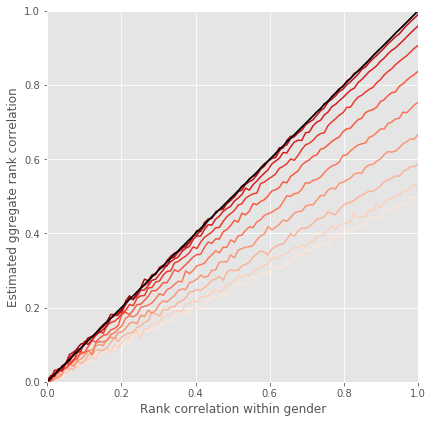

In [14]:
fig,ax = plt.subplots(figsize=(6,6))
map_color = itertools.cycle(sns.color_palette("Reds",len(a_list)))
for a in a_list:
    c = next(map_color)
    temp = rho_hat_df[rho_hat_df['a']==a]
    ax.plot(temp['rho'],temp['rho_hat'],color=c)
ax.plot(temp['rho'],temp['rho'],color='k', label='$45^\circ$')
ax.set_ylabel(r'Estimated ggregate rank correlation')
ax.set_xlabel(r'Rank correlation within gender')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()